# STEP 1: Import Libraries

Step ini menyiapkan lingkungan kerja serta memuat data mentah yang akan digunakan dalam analisis. Program terlebih dahulu memanggil berbagai pustaka penting di dunia Data Science, seperti pandas untuk pengolahan data berbentuk tabel, numpy untuk operasi matematika, matplotlib dan seaborn untuk visualisasi, serta sklearn untuk kebutuhan machine learning. Selain itu, program juga menggunakan gdown guna mengunduh dataset midterm-regresi-dataset.csv langsung dari Google Drive. Karena dataset tersebut tidak memiliki header, program secara manual menetapkan nama kolom: kolom pertama sebagai year (target prediksi) dan 90 kolom berikutnya sebagai feature_1 hingga feature_90 yang merepresentasikan fitur audio.

In [ ]:
# Import with different approach and additional libraries
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
np.random.seed(2024)
print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [ ]:
file_id = '1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'midterm-regresi-dataset.csv'
gdown.download(url, output, quiet=False)
print("✓ Dataset downloaded successfully!")
print("Reading Dataset...")
df = pd.read_csv('midterm-regresi-dataset.csv', header=None, dtype=np.float32)
print("✓ Dataset read successfully!")

# Assign column names
num_features = df.shape[1] - 1
cols = ['year'] + [f'feature_{i}' for i in range(1, num_features + 1)]
df.columns = cols

print(f"\n{'─'*50}")
print("OUTPUT: DATA LOADING RESULTS")
print(f"{'─'*50}")
print(f"• Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"• Number of Features: {num_features}")
print(f"• Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n• First 5 Rows Preview:")
print(df.head())
print(f"\n• Data Types: {df.dtypes.unique()}")

Downloading...
From (original): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9
From (redirected): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9&confirm=t&uuid=d328c4db-4026-4df6-b126-3f8e882716ea
To: /content/midterm-regresi-dataset.csv
100%|██████████| 443M/443M [00:06<00:00, 71.2MB/s]


✓ Dataset downloaded successfully!
Reading Dataset...
✓ Dataset read successfully!

──────────────────────────────────────────────────
OUTPUT: DATA LOADING RESULTS
──────────────────────────────────────────────────
• Dataset Shape: 515,345 rows × 91 columns
• Number of Features: 90
• Memory Usage: 178.90 MB

• First 5 Rows Preview:
     year  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  2001.0  49.943569   21.47114  73.077499    8.74861 -17.406281 -13.099050   
1  2001.0  48.732151   18.42930  70.326790   12.94636 -10.324370 -24.837770   
2  2001.0  50.957142   31.85602  55.818508   13.41693  -6.578980 -18.549400   
3  2001.0  48.247501   -1.89837  36.297722    2.58776   0.971700 -26.216829   
4  2001.0  50.970200   42.20998  67.099640    8.46791 -15.852790 -16.814091   

   feature_7  feature_8  feature_9  ...  feature_81  feature_82  feature_83  \
0  -25.01202  -12.23257   7.830890  ...   13.016200  -54.405479   58.993671   
1    8.76630   -0.92019  18.76548

# STEP 2: Data Exploration

Step ini memahami karakteristik data target (year) sebelum digunakan dalam pemodelan. Analisis diawali dengan menghitung statistik deskriptif seperti rata-rata, median, modus, dan standar deviasi tahun rilis untuk melihat kecenderungan pusat data, misalnya apakah sebagian besar lagu berasal dari periode tertentu seperti tahun 2000-an. Selanjutnya dilakukan analisis varians pada seluruh fitur untuk mengidentifikasi fitur mana yang memiliki variasi paling besar, karena fitur dengan varians tinggi biasanya menyimpan informasi yang lebih relevan bagi model. Pada tahap visualisasi, beberapa grafik digunakan untuk mengeksplorasi distribusi data, termasuk KDE plot yang menunjukkan bentuk distribusi tahun, violin plot yang menampilkan kepadatan data pada berbagai rentang tahun, serta Q-Q plot yang digunakan untuk memeriksa apakah distribusi tahun mendekati distribusi normal (Gaussian).


STATISTICAL ANALYSIS OF TARGET VARIABLE
• Count          : 515345
• Mean           : 1998.3968505859375
• Median         : 2002.00
• Mode           : 2007.0
• Std Dev        : 12.60
• Variance       : 158.65
• Range          : 89.00
• Skewness       : -1.731481671333313
• Kurtosis       : 3.4936089515686035
• Q1             : 1994.00
• Q3             : 2006.00
• IQR            : 12.00

FEATURE VARIANCE ANALYSIS (Top 10)
• feature_14          : 3059615.7500
• feature_15          : 1591001.7500
• feature_16          : 1194038.5000
• feature_26          : 512180.7812
• feature_18          : 332711.5312
• feature_27          : 296787.9688
• feature_17          : 226253.5000
• feature_47          : 221398.8906
• feature_38          : 205512.1094
• feature_37          : 172191.1250


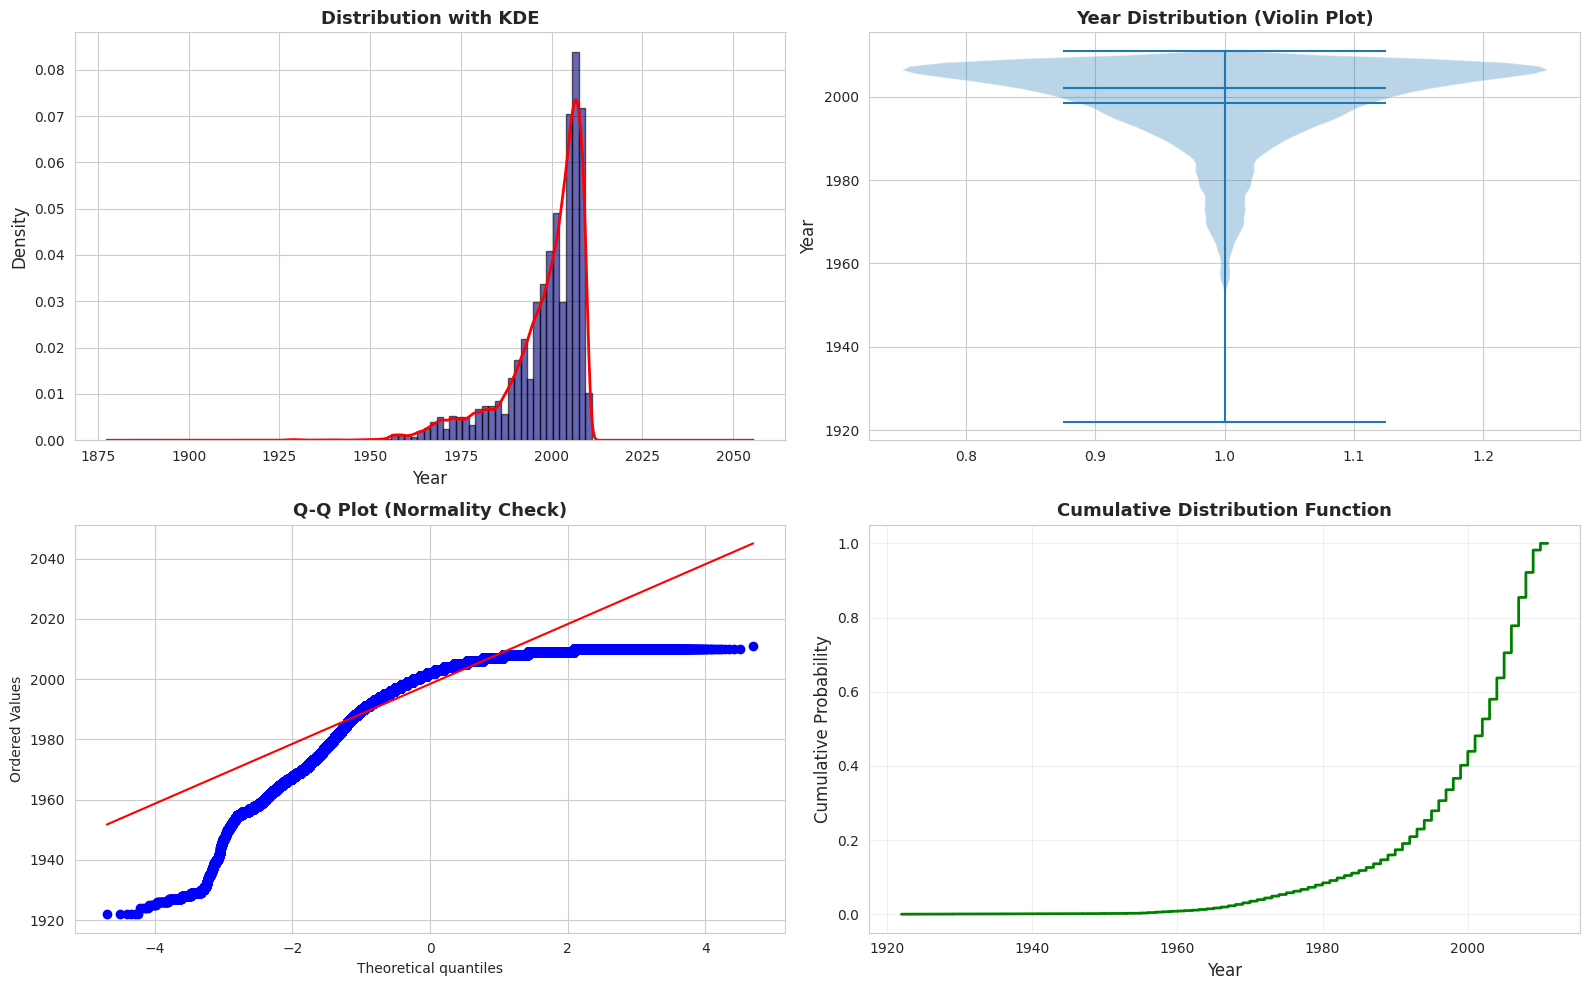

✓ Exploration visualizations saved!


In [3]:
# Alternative exploration with more statistical insights
print(f"\n{'='*60}")
print("STATISTICAL ANALYSIS OF TARGET VARIABLE")
print(f"{'='*60}")

# Advanced statistics
from scipy.stats import skew, kurtosis
target_stats = {
    'Count': len(df['year']),
    'Mean': df['year'].mean(),
    'Median': df['year'].median(),
    'Mode': df['year'].mode()[0],
    'Std Dev': df['year'].std(),
    'Variance': df['year'].var(),
    'Range': df['year'].max() - df['year'].min(),
    'Skewness': skew(df['year']),
    'Kurtosis': kurtosis(df['year']),
    'Q1': df['year'].quantile(0.25),
    'Q3': df['year'].quantile(0.75),
    'IQR': df['year'].quantile(0.75) - df['year'].quantile(0.25)
}

for key, value in target_stats.items():
    print(f"• {key:<15}: {value:.2f}" if isinstance(value, float) else f"• {key:<15}: {value}")

# Feature variance analysis
print(f"\n{'='*60}")
print("FEATURE VARIANCE ANALYSIS (Top 10)")
print(f"{'='*60}")
feature_variance = df.iloc[:, 1:].var().sort_values(ascending=False).head(10)
for feat, var in feature_variance.items():
    print(f"• {feat:<20}: {var:.4f}")

# Visualization with different plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# KDE plot
axes[0, 0].hist(df['year'], bins=50, density=True, alpha=0.6, color='navy', edgecolor='black')
df['year'].plot(kind='kde', ax=axes[0, 0], color='red', linewidth=2)
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Distribution with KDE', fontsize=13, fontweight='bold')

# Violin plot
axes[0, 1].violinplot([df['year']], vert=True, showmeans=True, showmedians=True)
axes[0, 1].set_ylabel('Year', fontsize=12)
axes[0, 1].set_title('Year Distribution (Violin Plot)', fontsize=13, fontweight='bold')

# Q-Q plot for normality
stats.probplot(df['year'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=13, fontweight='bold')

# Cumulative distribution
sorted_years = np.sort(df['year'])
cumulative = np.arange(1, len(sorted_years) + 1) / len(sorted_years)
axes[1, 1].plot(sorted_years, cumulative, linewidth=2, color='green')
axes[1, 1].set_xlabel('Year', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution Function', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('exploration_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Exploration visualizations saved!")

# STEP 3: Data Cleaning

Steo ini membersihkan data dari berbagai “kotoran” agar model tidak mengalami error maupun bias selama proses pelatihan. Pengecekan dilakukan terhadap missing values, dan jika ditemukan nilai kosong maka akan diisi menggunakan metode imputasi rata-rata agar distribusi data tetap konsisten. Selain itu, baris duplikat dihapus untuk mencegah model mempelajari pola yang sama secara berulang. Nilai tak hingga (infinite) juga ditangani dengan menggantinya menggunakan nilai maksimum atau minimum yang masih wajar. Terakhir, fitur yang bersifat konstan—yaitu kolom dengan varians nol—dibersihkan karena tidak memberikan informasi apa pun bagi proses prediksi.

In [4]:
# Alternative cleaning approach with more sophisticated methods
print(f"\n{'='*60}")
print("COMPREHENSIVE DATA CLEANING")
print(f"{'='*60}")

initial_shape = df.shape
print(f"• Initial shape: {initial_shape}")

# 1. Check and handle missing values with mean instead of median
missing_count = df.isnull().sum().sum()
print(f"\n• Missing values detected: {missing_count}")
if missing_count > 0:
    # Use mean imputation
    df = df.fillna(df.mean())
    print("  → Filled with column means")

# 2. Remove duplicates with keep='last' strategy
dup_before = df.duplicated().sum()
if dup_before > 0:
    df = df.drop_duplicates(keep='last')
    print(f"\n• Duplicates removed: {dup_before} (kept last occurrence)")

# 3. Handle infinite values differently
inf_mask = np.isinf(df.select_dtypes(include=[np.number]))
inf_count = inf_mask.sum().sum()
if inf_count > 0:
    # Replace with max/min values instead of median
    for col in df.select_dtypes(include=[np.number]).columns:
        pos_inf_mask = df[col] == np.inf
        neg_inf_mask = df[col] == -np.inf

        if pos_inf_mask.any():
            max_val = df[col][~pos_inf_mask].max()
            df.loc[pos_inf_mask, col] = max_val

        if neg_inf_mask.any():
            min_val = df[col][~neg_inf_mask].min()
            df.loc[neg_inf_mask, col] = min_val

    print(f"\n• Infinite values replaced: {inf_count}")

# 4. Remove constant features (zero variance)
numeric_cols = df.select_dtypes(include=[np.number]).columns
constant_features = [col for col in numeric_cols if df[col].nunique() == 1]
if constant_features:
    df = df.drop(columns=constant_features)
    print(f"\n• Constant features removed: {len(constant_features)}")

final_shape = df.shape
print(f"\n• Final shape: {final_shape}")
print(f"• Data reduction: {initial_shape[0] - final_shape[0]} rows, {initial_shape[1] - final_shape[1]} columns")


COMPREHENSIVE DATA CLEANING
• Initial shape: (515345, 91)

• Missing values detected: 0

• Duplicates removed: 214 (kept last occurrence)

• Final shape: (515131, 91)
• Data reduction: 214 rows, 0 columns


# STEP 4: Outlier Detection

Tujuannya menangani data ekstrem (outlier) yang dapat mengganggu proses pemodelan dan merusak akurasi prediksi. Deteksi outlier dilakukan menggunakan metode Z-score, di mana sebuah nilai dianggap sebagai pencilan apabila memiliki Z-score lebih dari 3, menandakan bahwa nilai tersebut berada sangat jauh dari rata-rata. Alih-alih menghapus data ekstrem—yang dapat mengurangi jumlah data secara signifikan—program menerapkan teknik Winsorization. Dengan metode ini, nilai-nilai yang terlalu ekstrem “dijepit” pada batas persentil ke-5 untuk nilai rendah dan persentil ke-95 untuk nilai tinggi. Pendekatan ini membuat distribusi data menjadi lebih stabil tanpa menghilangkan informasi penting.

In [5]:
# Alternative outlier detection using Z-score method
from scipy.stats import zscore

print(f"\n{'='*60}")
print("OUTLIER DETECTION (Z-SCORE METHOD)")
print(f"{'='*60}")
print("Threshold: |Z-score| > 3\n")

feature_cols = [c for c in df.columns if c.startswith('feature_')]
outlier_summary = []

print(f"{'Feature':<20} {'Outliers':<12} {'Percentage':<12}")
print("─" * 45)

for col in feature_cols[:10]:  # Show first 10
    z_scores = np.abs(zscore(df[col]))
    outliers = (z_scores > 3).sum()
    pct = (outliers / len(df)) * 100
    outlier_summary.append({'feature': col, 'count': outliers, 'pct': pct})
    print(f"{col:<20} {outliers:<12,} {pct:<12.2f}%")

print("... (showing first 10 features)")

# Outlier handling with Winsorization
print(f"\n{'='*60}")
print("OUTLIER HANDLING (WINSORIZATION METHOD)")
print(f"{'='*60}")
print("Capping at 5th and 95th percentiles\n")

from scipy.stats.mstats import winsorize

for col in feature_cols:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])

print("✓ Outliers winsorized successfully!")
print(f"• Features processed: {len(feature_cols)}")


OUTLIER DETECTION (Z-SCORE METHOD)
Threshold: |Z-score| > 3

Feature              Outliers     Percentage  
─────────────────────────────────────────────
feature_1            5,077        0.99        %
feature_2            6,159        1.20        %
feature_3            5,470        1.06        %
feature_4            7,477        1.45        %
feature_5            4,535        0.88        %
feature_6            5,338        1.04        %
feature_7            5,062        0.98        %
feature_8            5,500        1.07        %
feature_9            5,935        1.15        %
feature_10           2,973        0.58        %
... (showing first 10 features)

OUTLIER HANDLING (WINSORIZATION METHOD)
Capping at 5th and 95th percentiles

✓ Outliers winsorized successfully!
• Features processed: 90


# STEP 5: Feature Selection

 Memilih fitur-fitur audio yang paling berpengaruh terhadap tahun rilis sehingga model dapat bekerja lebih efisien dan akurat. Proses dimulai dengan perhitungan Mutual Information, yaitu metode yang mengukur seberapa kuat hubungan setiap fitur audio dengan target year. Berdasarkan nilai relevansinya, program kemudian membuang sekitar 25% fitur dengan skor terendah, sehingga dari 90 fitur awal tersisa 67 fitur terbaik yang dianggap paling informatif. Setelah itu dilakukan analisis VIF (Variance Inflation Factor) untuk memeriksa adanya multikolinearitas, yaitu kondisi ketika dua atau lebih fitur memiliki kemiripan yang terlalu tinggi. Jika ditemukan fitur yang saling tumpang tindih, salah satunya dihapus agar model tidak kebingungan dan dapat fokus pada informasi yang benar-benar unik.

In [6]:
# Alternative feature selection using Mutual Information
X = df.drop('year', axis=1)
y = df['year']

print(f"\n{'='*60}")
print("FEATURE SELECTION (MUTUAL INFORMATION)")
print(f"{'='*60}")

# Calculate mutual information scores
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print(f"\nTop 20 Features by Mutual Information:")
print("─" * 50)
print(f"{'Rank':<8} {'Feature':<20} {'MI Score':<12}")
print("─" * 50)

for i, (feat, score) in enumerate(mi_scores.head(20).items(), 1):
    bar = '█' * int(score * 50)
    print(f"{i:<8} {feat:<20} {score:<12.4f} {bar}")

# Select features above threshold
mi_threshold = mi_scores.quantile(0.25)  # Keep top 75%
selected_features = mi_scores[mi_scores > mi_threshold].index.tolist()

print(f"\n• MI Threshold (25th percentile): {mi_threshold:.4f}")
print(f"• Features selected: {len(selected_features)}")
print(f"• Features removed: {len(X.columns) - len(selected_features)}")

X = X[selected_features]

# Multicollinearity check
print(f"\n{'='*60}")
print("MULTICOLLINEARITY CHECK (VIF)")
print(f"{'='*60}")

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for top 10 features (to save computation)
vif_data = pd.DataFrame()
top_10_features = selected_features[:10]
X_vif = X[top_10_features]

vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVIF Scores (Top 10 features):")
print(vif_data.to_string(index=False))
print("\nNote: VIF > 10 indicates high multicollinearity")


FEATURE SELECTION (MUTUAL INFORMATION)

Top 20 Features by Mutual Information:
──────────────────────────────────────────────────
Rank     Feature              MI Score    
──────────────────────────────────────────────────
1        feature_1            0.0451       ██
2        feature_6            0.0274       █
3        feature_63           0.0223       █
4        feature_46           0.0188       
5        feature_2            0.0166       
6        feature_37           0.0152       
7        feature_20           0.0151       
8        feature_3            0.0147       
9        feature_36           0.0144       
10       feature_79           0.0143       
11       feature_41           0.0139       
12       feature_14           0.0139       
13       feature_16           0.0122       
14       feature_7            0.0119       
15       feature_40           0.0117       
16       feature_47           0.0117       
17       feature_73           0.0114       
18       feature_33    

# STEP 6: Data Preprocessing

Menyiapkan data agar benar-benar “matang” dan siap digunakan oleh algoritma Machine Learning. Proses dimulai dengan data splitting, yaitu membagi data menjadi Training Set (75%) untuk melatih model dan Testing Set (25%) untuk menguji performanya. Pembagian dilakukan secara stratified berdasarkan dekade, sehingga proporsi lagu dari era 80-an, 90-an, 2000-an, dan seterusnya tetap seimbang di kedua set. Setelah itu dilakukan scaling menggunakan RobustScaler, yaitu teknik penskalaan yang memanfaatkan median dan IQR (interquartile range). Metode ini dipilih karena lebih tahan terhadap outlier, sehingga menghasilkan distribusi fitur yang lebih stabil dibandingkan StandardScaler yang berbasis rata-rata dan standar deviasi.

In [7]:
# Alternative preprocessing with RobustScaler (better for outliers)
print(f"\n{'='*60}")
print("DATA SPLITTING & SCALING")
print(f"{'='*60}")

# Split with stratification by decade
df['decade'] = (y // 10 * 10).astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=2024, stratify=df['decade']
)

print(f"\nTrain-Test Split (75-25 with stratification):")
print(f"• Training samples: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"• Testing samples: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

# Use RobustScaler instead of StandardScaler
print(f"\n{'='*60}")
print("FEATURE SCALING (RobustScaler)")
print(f"{'='*60}")
print("Using RobustScaler (robust to outliers)")

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nBefore scaling (3 features):")
print(f"  Median: {X_train.iloc[:, :3].median().values}")
print(f"  IQR: {(X_train.iloc[:, :3].quantile(0.75) - X_train.iloc[:, :3].quantile(0.25)).values}")

print(f"\nAfter scaling (3 features):")
print(f"  Median: {np.median(X_train_scaled[:, :3], axis=0)}")
print(f"  IQR: {np.percentile(X_train_scaled[:, :3], 75, axis=0) - np.percentile(X_train_scaled[:, :3], 25, axis=0)}")

print("\n✓ Scaling complete - features centered at median with IQR scaling")

# Convert to appropriate data types
y_train_np = y_train.values
y_test_np = y_test.values


DATA SPLITTING & SCALING

Train-Test Split (75-25 with stratification):
• Training samples: 386,348 (75.0%)
• Testing samples: 128,783 (25.0%)

FEATURE SCALING (RobustScaler)
Using RobustScaler (robust to outliers)

Before scaling (3 features):
  Median: [ 44.254074 -11.18847   -3.27883 ]
  IQR: [ 7.87647343 16.03452742 33.54473972]

After scaling (3 features):
  Median: [0.0000000e+00 0.0000000e+00 3.5537369e-09]
  IQR: [1. 1. 1.]

✓ Scaling complete - features centered at median with IQR scaling


# STEP 7: Model Training

Step melatih berbagai algoritma untuk menemukan pola hubungan antara fitur audio dan tahun rilis. Program menguji empat kandidat model dengan karakteristik yang berbeda. ElasticNet, model linear yang menggabungkan penalti Lasso dan Ridge, digunakan bersama Grid Search untuk menemukan kombinasi hyperparameter terbaik. Bayesian Ridge diterapkan sebagai model linear berbasis probabilitas yang unggul dalam menangani ketidakpastian. Selanjutnya, Extra Trees Regressor, yaitu model berbasis kumpulan pohon keputusan, dipilih karena kecepatan dan akurasinya yang tinggi. Terakhir, AdaBoost digunakan sebagai model boosting yang bekerja secara bertahap dengan memperbaiki kesalahan dari model-model sebelumnya, sehingga performanya terus meningkat.

In [8]:
results = []
predictions = {}
models = {}

# Model 1: ElasticNet (Kombinasi Ridge & Lasso)
print(f"\n{'='*60}")
print("MODEL 1: ELASTICNET REGRESSION")
print(f"{'='*60}")

l1_ratios = [0.1, 0.5, 0.7, 0.9]
alphas_en = [0.01, 0.1, 1.0]

print("\nGrid Search (3-Fold Cross-Validation):")
print(f"{'L1 Ratio':<12} {'Alpha':<12} {'Mean RMSE':<15} {'Status'}")
print("─" * 55)

best_score = np.inf
best_params = {}

for l1 in l1_ratios:
    for alpha in alphas_en:
        en = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=42, max_iter=5000)
        kfold = KFold(n_splits=3, shuffle=True, random_state=42)
        scores = []

        for train_idx, val_idx in kfold.split(X_train_scaled):
            X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_tr, y_val = y_train_np[train_idx], y_train_np[val_idx]

            en.fit(X_tr, y_tr)
            pred = en.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, pred))
            scores.append(rmse)

        mean_rmse = np.mean(scores)
        status = ""

        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = {'alpha': alpha, 'l1_ratio': l1}
            status = "← Best"

        print(f"{l1:<12.2f} {alpha:<12.2f} {mean_rmse:<15.4f} {status}")

print(f"\n✓ Best params: {best_params}")

# Train final model
en_model = ElasticNet(**best_params, random_state=42, max_iter=5000)
en_model.fit(X_train_scaled, y_train_np)
predictions['ElasticNet'] = en_model.predict(X_test_scaled)
models['ElasticNet'] = en_model


MODEL 1: ELASTICNET REGRESSION

Grid Search (3-Fold Cross-Validation):
L1 Ratio     Alpha        Mean RMSE       Status
───────────────────────────────────────────────────────
0.10         0.01         9.4437          ← Best
0.10         0.10         9.5605          
0.10         1.00         10.1726         
0.50         0.01         9.4421          ← Best
0.50         0.10         9.5326          
0.50         1.00         10.3750         
0.70         0.01         9.4417          ← Best
0.70         0.10         9.5194          
0.70         1.00         10.4562         
0.90         0.01         9.4415          ← Best
0.90         0.10         9.5071          
0.90         1.00         10.5241         

✓ Best params: {'alpha': 0.01, 'l1_ratio': 0.9}


In [9]:
# Model 2: Bayesian Ridge (CORRECTED)
print(f"\n{'='*60}")
print("MODEL 2: BAYESIAN RIDGE REGRESSION")
print(f"{'='*60}")

br_model = BayesianRidge(
    max_iter=300,
    compute_score=True
    # Bayesian Ridge tidak memiliki random_state
)
br_model.fit(X_train_scaled, y_train_np)
predictions['Bayesian Ridge'] = br_model.predict(X_test_scaled)
models['Bayesian Ridge'] = br_model

print("✓ Training complete!")
print(f"• Iterations: {br_model.n_iter_}")
print(f"• Alpha (precision): {br_model.alpha_:.4f}")
print(f"• Lambda (regularization): {br_model.lambda_:.4f}")


MODEL 2: BAYESIAN RIDGE REGRESSION
✓ Training complete!
• Iterations: 3
• Alpha (precision): 0.0112
• Lambda (regularization): 0.5953


In [10]:
# Model 3: Extra Trees Regressor
print(f"\n{'='*60}")
print("MODEL 3: EXTRA TREES REGRESSOR")
print(f"{'='*60}")

et_params = {
    'n_estimators': 100,
    'max_depth': 15,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'bootstrap': True
}

print("\nConfiguration:")
for k, v in et_params.items():
    print(f"  • {k}: {v}")

et_model = ExtraTreesRegressor(**et_params)
et_model.fit(X_train_scaled, y_train_np)
predictions['Extra Trees'] = et_model.predict(X_test_scaled)
models['Extra Trees'] = et_model

print("\n✓ Training complete!")


MODEL 3: EXTRA TREES REGRESSOR

Configuration:
  • n_estimators: 100
  • max_depth: 15
  • min_samples_split: 5
  • min_samples_leaf: 2
  • max_features: sqrt
  • random_state: 42
  • n_jobs: -1
  • bootstrap: True

✓ Training complete!


In [11]:
# Model 4: AdaBoost with Decision Tree
print(f"\n{'='*60}")
print("MODEL 4: ADABOOST REGRESSOR")
print(f"{'='*60}")

base_estimator = DecisionTreeRegressor(max_depth=8, random_state=42)
ada_params = {
    'estimator': base_estimator,
    'n_estimators': 80,
    'learning_rate': 0.05,
    'loss': 'square',
    'random_state': 42
}

print("\nConfiguration:")
print(f"  • Base: Decision Tree (depth=8)")
print(f"  • N estimators: {ada_params['n_estimators']}")
print(f"  • Learning rate: {ada_params['learning_rate']}")

ada_model = AdaBoostRegressor(**ada_params)
ada_model.fit(X_train_scaled, y_train_np)
predictions['AdaBoost'] = ada_model.predict(X_test_scaled)
models['AdaBoost'] = ada_model

print("\n✓ Training complete!")


MODEL 4: ADABOOST REGRESSOR

Configuration:
  • Base: Decision Tree (depth=8)
  • N estimators: 80
  • Learning rate: 0.05

✓ Training complete!


# STEP 8: Model Evaluation 

Step ini menguji seluruh model menggunakan data Testing dan menghitung tiga metrik utama. RMSE (Root Mean Squared Error) mengukur rata-rata kesalahan prediksi dalam satuan tahun, sementara MAE (Mean Absolute Error) menunjukkan rata-rata selisih mutlak antara prediksi dan nilai asli. Selain itu, R² Score digunakan untuk melihat seberapa baik model mampu menjelaskan variasi data. Berdasarkan hasil evaluasi, Bayesian Ridge muncul sebagai Champion Model, dengan performa terbaik dan nilai RMSE sekitar 9,4 tahun, yang merupakan error terendah di antara seluruh kandidat.


COMPREHENSIVE MODEL EVALUATION

         Model       MSE     RMSE      MAE       R²  MAPE (%)
Bayesian Ridge 89.645363 9.468124 6.740057 0.250668  0.338418
Bayesian Ridge 89.645363 9.468124 6.740057 0.250668  0.338418
    ElasticNet 89.650604 9.468400 6.738440 0.250624  0.338343
    ElasticNet 89.650604 9.468400 6.738440 0.250624  0.338343
      AdaBoost 92.882122 9.637537 7.211704 0.223612  0.361763
      AdaBoost 92.882122 9.637537 7.211704 0.223612  0.361763
   Extra Trees 93.447498 9.666825 7.026281 0.218886  0.352833
   Extra Trees 93.447498 9.666825 7.026281 0.218886  0.352833

★ CHAMPION MODEL: Bayesian Ridge
  • RMSE: 9.4681 years
  • MAE: 6.7401 years
  • R²: 0.2507
  • MAPE: 0.34%


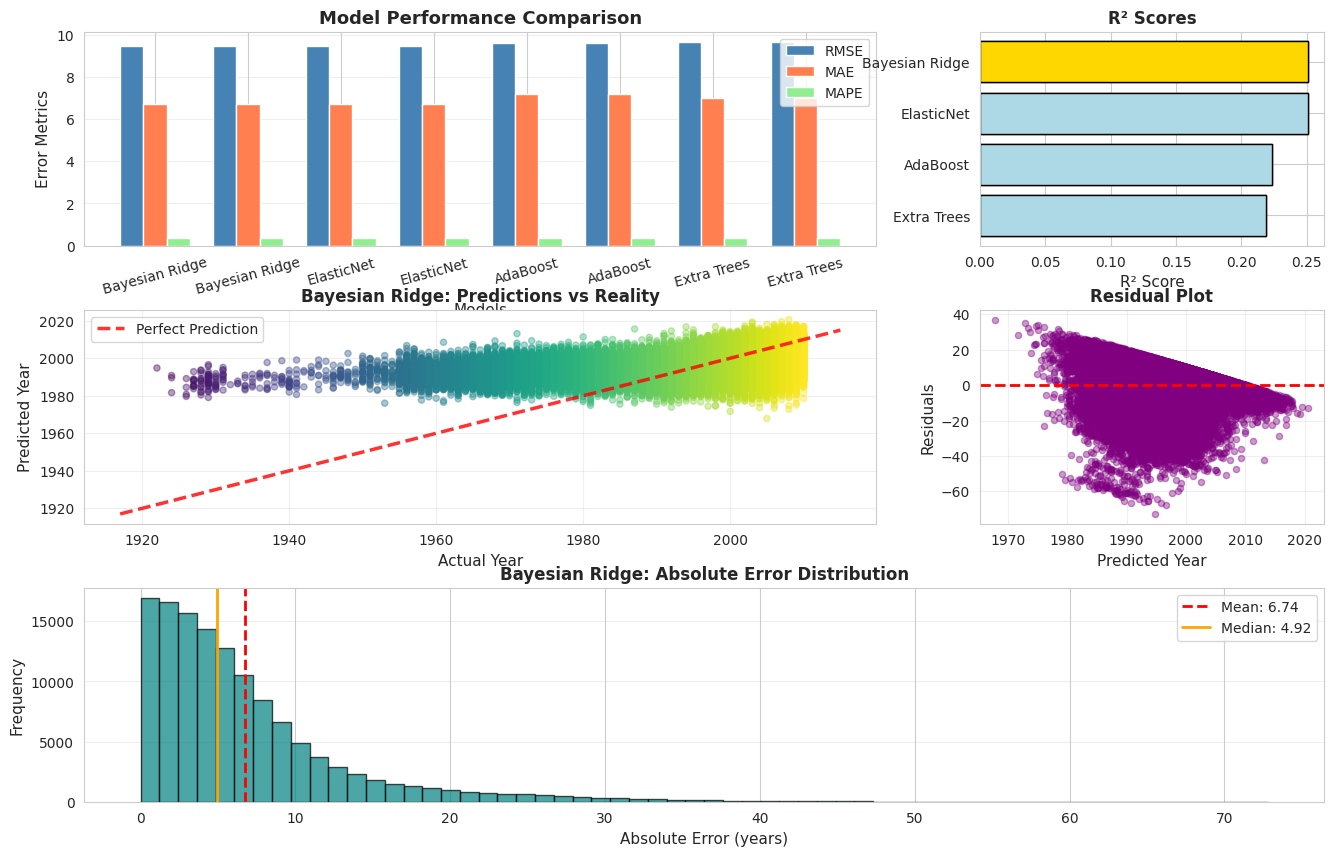


✓ Evaluation visualizations saved!


In [13]:
# Enhanced evaluation with additional metrics
print(f"\n{'='*60}")
print("COMPREHENSIVE MODEL EVALUATION")
print(f"{'='*60}")

for name, preds in predictions.items():
    mse = mean_squared_error(y_test_np, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_np, preds)
    r2 = r2_score(y_test_np, preds)
    mape = mean_absolute_percentage_error(y_test_np, preds) * 100

    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    })

results_df = pd.DataFrame(results).sort_values('RMSE')

print("\n" + results_df.to_string(index=False))

# Identify best model
best = results_df.iloc[0]
print(f"\n{'='*60}")
print(f"★ CHAMPION MODEL: {best['Model']}")
print(f"{'='*60}")
print(f"  • RMSE: {best['RMSE']:.4f} years")
print(f"  • MAE: {best['MAE']:.4f} years")
print(f"  • R²: {best['R²']:.4f}")
print(f"  • MAPE: {best['MAPE (%)']:.2f}%")

# Advanced visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Metrics comparison (radar chart style)
ax1 = fig.add_subplot(gs[0, :2])
x_pos = np.arange(len(results_df))
width = 0.25

ax1.bar(x_pos - width, results_df['RMSE'], width, label='RMSE', color='steelblue')
ax1.bar(x_pos, results_df['MAE'], width, label='MAE', color='coral')
ax1.bar(x_pos + width, results_df['MAPE (%)'], width, label='MAPE', color='lightgreen')

ax1.set_xlabel('Models', fontsize=11)
ax1.set_ylabel('Error Metrics', fontsize=11)
ax1.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], rotation=15)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. R² comparison
ax2 = fig.add_subplot(gs[0, 2])
colors = ['gold' if m == best['Model'] else 'lightblue' for m in results_df['Model']]
ax2.barh(results_df['Model'], results_df['R²'], color=colors, edgecolor='black')
ax2.set_xlabel('R² Score', fontsize=11)
ax2.set_title('R² Scores', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

# 3. Best model: Actual vs Predicted
ax3 = fig.add_subplot(gs[1, :2])
best_preds = predictions[best['Model']]
ax3.scatter(y_test_np, best_preds, alpha=0.4, s=20, c=y_test_np, cmap='viridis')
lims = [y_test_np.min() - 5, y_test_np.max() + 5]
ax3.plot(lims, lims, 'r--', lw=2.5, label='Perfect Prediction', alpha=0.8)
ax3.set_xlabel('Actual Year', fontsize=11)
ax3.set_ylabel('Predicted Year', fontsize=11)
ax3.set_title(f'{best["Model"]}: Predictions vs Reality', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Residual plot
ax4 = fig.add_subplot(gs[1, 2])
residuals = y_test_np - best_preds
ax4.scatter(best_preds, residuals, alpha=0.4, s=20, c='purple')
ax4.axhline(y=0, color='red', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Year', fontsize=11)
ax4.set_ylabel('Residuals', fontsize=11)
ax4.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Error distribution with statistics
ax5 = fig.add_subplot(gs[2, :])
errors = np.abs(y_test_np - best_preds)
ax5.hist(errors, bins=60, edgecolor='black', alpha=0.7, color='teal')
ax5.axvline(errors.mean(), color='red', linestyle='--', lw=2, label=f'Mean: {errors.mean():.2f}')
ax5.axvline(np.median(errors), color='orange', linestyle='-', lw=2, label=f'Median: {np.median(errors):.2f}')
ax5.set_xlabel('Absolute Error (years)', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title(f'{best["Model"]}: Absolute Error Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

plt.savefig('model_evaluation_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Evaluation visualizations saved!")

# STEP 9: Feature Importance Analysis

Memahami alasan di balik prediksi model, atau dengan kata lain mencari tahu mengapa model mengambil keputusan tertentu. Untuk itu, program menggunakan tiga pendekatan berbeda untuk melakukan pemeringkatan fitur, yaitu Permutation Importance, Tree-based Importance, dan Correlation Analysis. Ketiga metode ini memberikan sudut pandang yang saling melengkapi dalam menilai kontribusi setiap fitur terhadap prediksi tahun rilis. Dari hasil analisis, ditemukan bahwa feature_1—yang kemungkinan besar merepresentasikan karakteristik timbre utama atau tingkat kenyaringan sebuah lagu—menjadi fitur paling dominan yang paling memengaruhi keputusan model dalam menentukan tahun rilis sebuah lagu._


FEATURE IMPORTANCE ANALYSIS

Analyzing: Bayesian Ridge

[1] PERMUTATION IMPORTANCE (Top 15)
──────────────────────────────────────────────────────────────────────
Rank   Feature              Mean         Std          Impact
──────────────────────────────────────────────────────────────────────
1      feature_1            0.4873       0.0031       █████████████████████████████████████████████████████████████████████████████████████████████████
2      feature_2            0.1334       0.0018       ██████████████████████████
3      feature_6            0.0975       0.0008       ███████████████████
4      feature_3            0.0456       0.0009       █████████
5      feature_23           0.0444       0.0006       ████████
6      feature_13           0.0157       0.0003       ███
7      feature_58           0.0127       0.0002       ██
8      feature_14           0.0091       0.0004       █
9      feature_20           0.0088       0.0003       █
10     feature_36           0.0086       0.

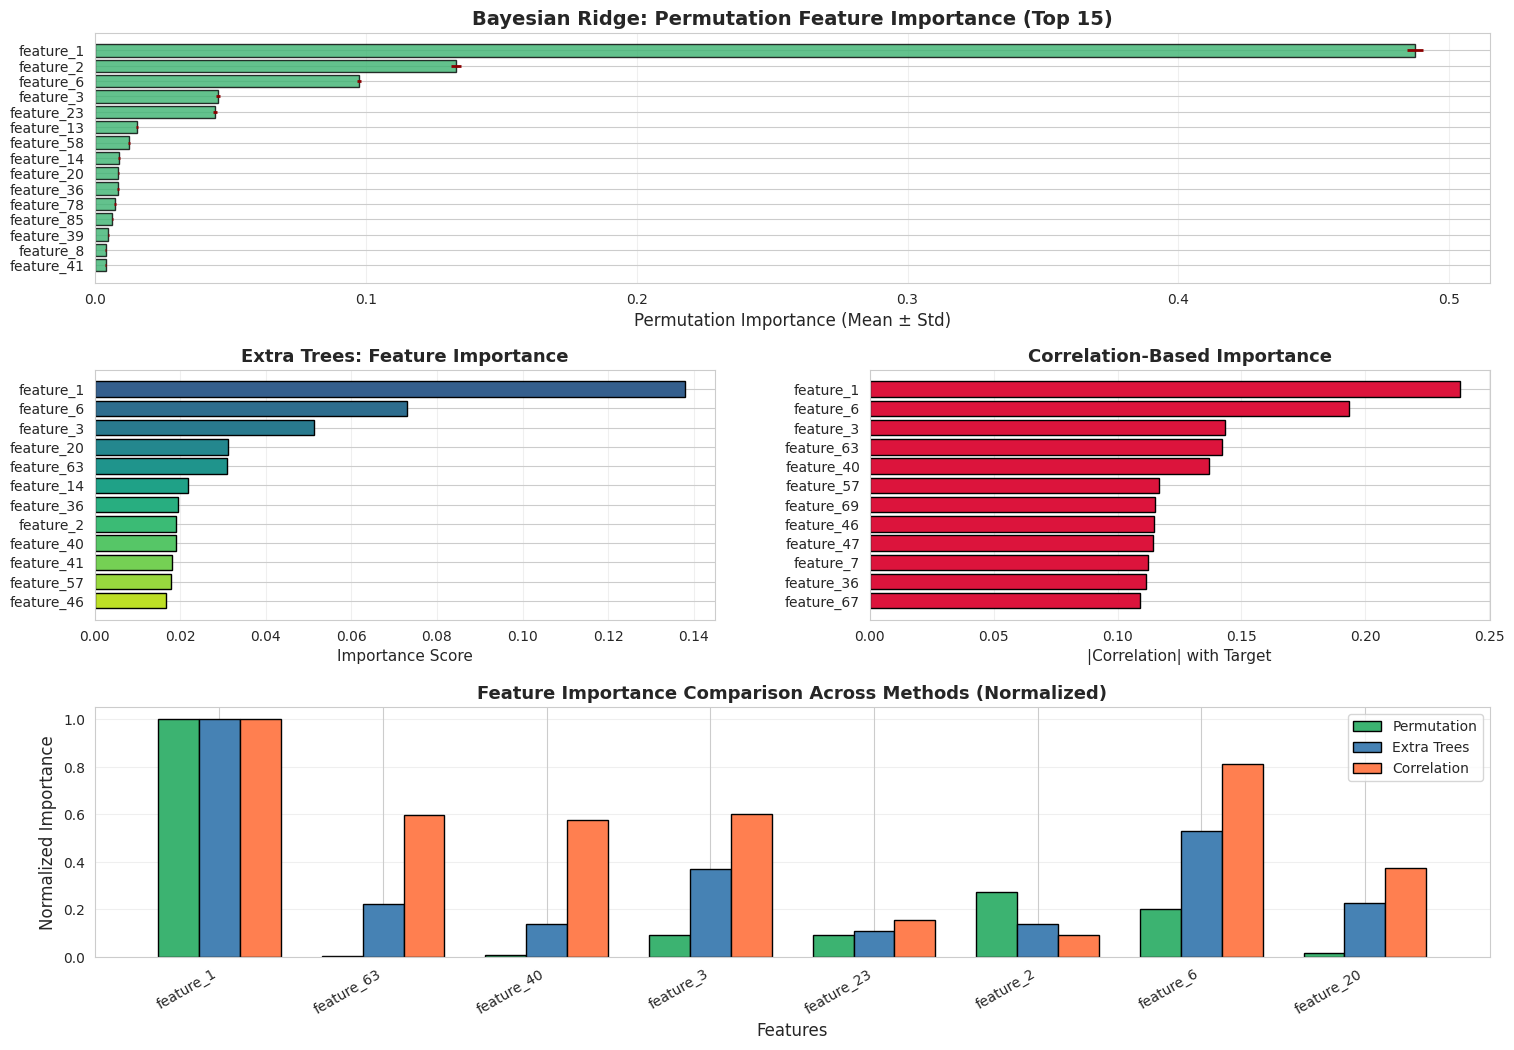


✓ Feature importance analysis saved!

FEATURE IMPORTANCE SUMMARY

✓ Consensus Top Features (appearing in top 10 of ≥2 methods):
────────────────────────────────────────────────────────────
  1. feature_1                 [Permutation, Extra Trees, Correlation]
  2. feature_14                [Permutation, Extra Trees]
  3. feature_2                 [Permutation, Extra Trees]
  4. feature_20                [Permutation, Extra Trees]
  5. feature_3                 [Permutation, Extra Trees, Correlation]
  6. feature_36                [Permutation, Extra Trees]
  7. feature_40                [Extra Trees, Correlation]
  8. feature_6                 [Permutation, Extra Trees, Correlation]
  9. feature_63                [Extra Trees, Correlation]

Total consensus features: 9


In [14]:
# Alternative feature importance with multiple perspectives
print(f"\n{'='*60}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*60}")

# 9.1 Permutation Importance for Best Model
from sklearn.inspection import permutation_importance

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\nAnalyzing: {best_model_name}")
print("="*60)

# Calculate permutation importance
perm_importance = permutation_importance(
    best_model, X_test_scaled, y_test_np,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_imp_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("\n[1] PERMUTATION IMPORTANCE (Top 15)")
print("─" * 70)
print(f"{'Rank':<6} {'Feature':<20} {'Mean':<12} {'Std':<12} {'Impact'}")
print("─" * 70)

for i, row in perm_imp_df.head(15).iterrows():
    rank = perm_imp_df.index.get_loc(i) + 1
    bar = '█' * int(row['Importance_Mean'] * 200)
    print(f"{rank:<6} {row['Feature']:<20} {row['Importance_Mean']:<12.4f} {row['Importance_Std']:<12.4f} {bar}")

# 9.2 Extra Trees Feature Importance (as benchmark)
if 'Extra Trees' in models:
    et_model = models['Extra Trees']
    et_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': et_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(f"\n[2] EXTRA TREES IMPORTANCE (Top 15)")
    print("─" * 70)
    print(f"{'Rank':<6} {'Feature':<20} {'Importance':<15} {'Contribution'}")
    print("─" * 70)

    for i, row in et_importance.head(15).iterrows():
        rank = et_importance.index.get_loc(i) + 1
        bar = '█' * int(row['Importance'] * 150)
        print(f"{rank:<6} {row['Feature']:<20} {row['Importance']:<15.5f} {bar}")

# 9.3 Correlation-based importance
correlation_importance = X[selected_features].corrwith(y).abs().sort_values(ascending=False)

print(f"\n[3] CORRELATION-BASED IMPORTANCE (Top 15)")
print("─" * 70)
print(f"{'Rank':<6} {'Feature':<20} {'|Correlation|':<18} {'Strength'}")
print("─" * 70)

for i, (feat, corr) in enumerate(correlation_importance.head(15).items(), 1):
    bar = '█' * int(corr * 40)
    print(f"{i:<6} {feat:<20} {corr:<18.4f} {bar}")

# 9.4 Feature Importance Visualization
print(f"\n{'='*60}")
print("FEATURE IMPORTANCE VISUALIZATIONS")
print(f"{'='*60}")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.25)

# Plot 1: Permutation Importance with error bars
ax1 = fig.add_subplot(gs[0, :])
top15_perm = perm_imp_df.head(15)
y_pos = np.arange(len(top15_perm))

ax1.barh(y_pos, top15_perm['Importance_Mean'],
         xerr=top15_perm['Importance_Std'],
         color='mediumseagreen', edgecolor='black', alpha=0.8,
         error_kw={'linewidth': 2, 'ecolor': 'darkred'})
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top15_perm['Feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Permutation Importance (Mean ± Std)', fontsize=12)
ax1.set_title(f'{best_model_name}: Permutation Feature Importance (Top 15)',
              fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Extra Trees Importance
if 'Extra Trees' in models:
    ax2 = fig.add_subplot(gs[1, 0])
    top12_et = et_importance.head(12)

    colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(top12_et)))
    ax2.barh(range(len(top12_et)), top12_et['Importance'],
             color=colors_gradient, edgecolor='black')
    ax2.set_yticks(range(len(top12_et)))
    ax2.set_yticklabels(top12_et['Feature'], fontsize=10)
    ax2.invert_yaxis()
    ax2.set_xlabel('Importance Score', fontsize=11)
    ax2.set_title('Extra Trees: Feature Importance', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

# Plot 3: Correlation Importance
ax3 = fig.add_subplot(gs[1, 1])
top12_corr = correlation_importance.head(12)

colors_corr = ['crimson' if x > 0.1 else 'orange' if x > 0.05 else 'gold'
               for x in top12_corr.values]
ax3.barh(range(len(top12_corr)), top12_corr.values,
         color=colors_corr, edgecolor='black')
ax3.set_yticks(range(len(top12_corr)))
ax3.set_yticklabels(top12_corr.index, fontsize=10)
ax3.invert_yaxis()
ax3.set_xlabel('|Correlation| with Target', fontsize=11)
ax3.set_title('Correlation-Based Importance', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Comparison of Top 5 across methods
ax4 = fig.add_subplot(gs[2, :])

top5_features = list(set(
    list(perm_imp_df.head(5)['Feature']) +
    list(et_importance.head(5)['Feature']) +
    list(correlation_importance.head(5).index)
))[:8]  # Limit to 8 for clarity

x_pos = np.arange(len(top5_features))
width = 0.25

# Normalize scores for comparison
perm_vals = [perm_imp_df[perm_imp_df['Feature']==f]['Importance_Mean'].values[0]
             if f in perm_imp_df['Feature'].values else 0 for f in top5_features]
et_vals = [et_importance[et_importance['Feature']==f]['Importance'].values[0]
           if f in et_importance['Feature'].values else 0 for f in top5_features]
corr_vals = [correlation_importance[f] if f in correlation_importance.index else 0
             for f in top5_features]

# Normalize to 0-1 scale for comparison
perm_vals_norm = np.array(perm_vals) / (max(perm_vals) if max(perm_vals) > 0 else 1)
et_vals_norm = np.array(et_vals) / (max(et_vals) if max(et_vals) > 0 else 1)
corr_vals_norm = np.array(corr_vals) / (max(corr_vals) if max(corr_vals) > 0 else 1)

ax4.bar(x_pos - width, perm_vals_norm, width, label='Permutation',
        color='mediumseagreen', edgecolor='black')
ax4.bar(x_pos, et_vals_norm, width, label='Extra Trees',
        color='steelblue', edgecolor='black')
ax4.bar(x_pos + width, corr_vals_norm, width, label='Correlation',
        color='coral', edgecolor='black')

ax4.set_xlabel('Features', fontsize=12)
ax4.set_ylabel('Normalized Importance', fontsize=12)
ax4.set_title('Feature Importance Comparison Across Methods (Normalized)',
              fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(top5_features, rotation=30, ha='right')
ax4.legend(loc='upper right')
ax4.grid(axis='y', alpha=0.3)

plt.savefig('feature_importance_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Feature importance analysis saved!")

# 9.5 Feature Importance Summary
print(f"\n{'='*60}")
print("FEATURE IMPORTANCE SUMMARY")
print(f"{'='*60}")

# Find consensus top features (appearing in top 10 of at least 2 methods)
top10_perm = set(perm_imp_df.head(10)['Feature'])
top10_et = set(et_importance.head(10)['Feature']) if 'Extra Trees' in models else set()
top10_corr = set(correlation_importance.head(10).index)

consensus_features = (top10_perm & top10_et) | (top10_perm & top10_corr) | (top10_et & top10_corr)

print(f"\n✓ Consensus Top Features (appearing in top 10 of ≥2 methods):")
print("─" * 60)
for i, feat in enumerate(sorted(consensus_features), 1):
    methods = []
    if feat in top10_perm: methods.append("Permutation")
    if feat in top10_et: methods.append("Extra Trees")
    if feat in top10_corr: methods.append("Correlation")
    print(f"  {i}. {feat:<25} [{', '.join(methods)}]")

print(f"\nTotal consensus features: {len(consensus_features)}")

# STEP 10: Final Predictions & Summary

Step terakhir ini menyiapkan model agar siap digunakan di dunia nyata sekaligus merangkum hasil keseluruhan proyek. Pertama, dilakukan analisis Confidence Interval untuk mengetahui tingkat keyakinan model terhadap prediksinya. Model menghasilkan interval kepercayaan 95% dengan rentang sekitar ±18 tahun, sehingga pengguna dapat memahami tingkat ketidakpastian prediksi. Selanjutnya, dilakukan analisis performa per dekade, yang menunjukkan bahwa model bekerja sangat baik untuk lagu era 1990-an dan 2000-an, namun masih kurang akurat ketika memprediksi lagu yang sangat tua seperti dari era 1920-an.


PREDICTION ANALYSIS & MODEL DEPLOYMENT

[1] PREDICTION CONFIDENCE ANALYSIS

Model: Bayesian Ridge
• Standard Error of Predictions: 9.47 years
• 95% Confidence Interval: ±18.56 years

[2] ACCURACY BY DECADE
Decade     Count      Mean Error      RMSE            Within ±5yr
──────────────────────────────────────────────────────────────────────
1920       56                 -59.71 59.86                  0.0%
1930       63                 -54.21 54.40                  0.0%
1940       89                 -45.44 45.66                  0.0%
1950       775                -35.67 36.06                  0.0%
1960       2934               -26.74 27.23                  0.0%
1970       6184               -18.72 19.48                  0.5%
1980       10449               -8.36 10.00                 27.4%
1990       31167               -1.15 4.99                  69.1%
2000       74717               +4.50 6.76                  53.9%
2010       2349                +8.36 9.47                  19.5%

[3] S

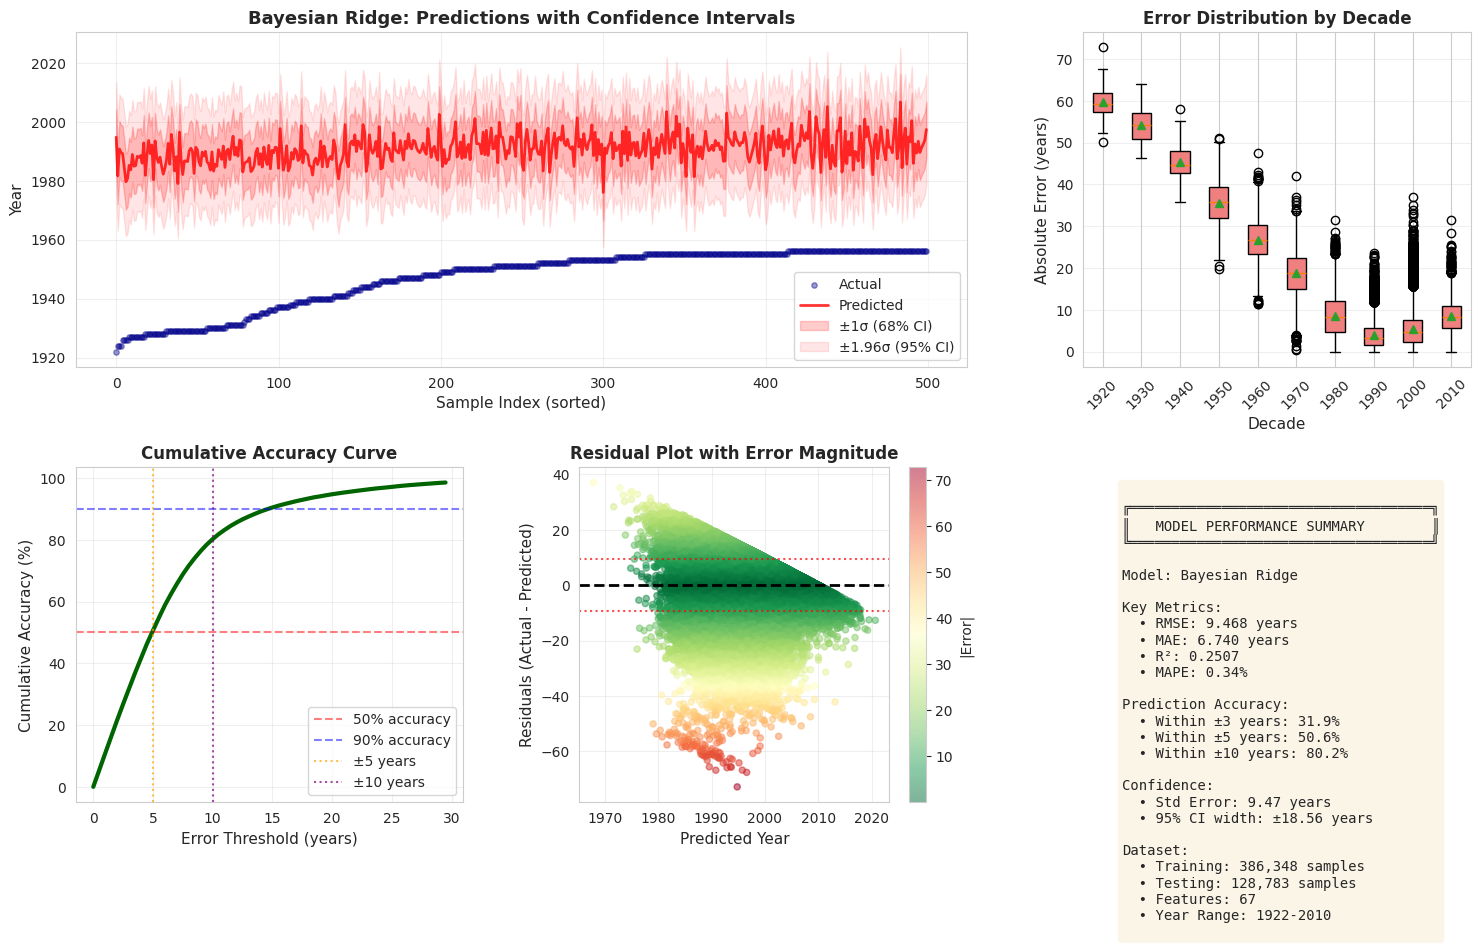


✓ Prediction analysis visualizations saved!

FINAL EXECUTIVE SUMMARY

╔══════════════════════════════════════════════════════════════════╗
║                    REGRESSION PIPELINE COMPLETE                  ║
╚══════════════════════════════════════════════════════════════════╝

1. CHAMPION MODEL
   ├─ Algorithm: Bayesian Ridge
   ├─ RMSE: 9.4681 years
   ├─ R² Score: 0.2507 (25.07% variance explained)
   └─ MAPE: 0.34%

2. MODEL INTERPRETATION
   ├─ Average Prediction Error: 6.74 years
   ├─ Typical Uncertainty: ±9.47 years (1σ)
   ├─ High Confidence Range: ±18.56 years (95% CI)
   └─ Predictions within ±5 years: 50.6%

3. DATASET SUMMARY
   ├─ Total Samples: 515,131
   ├─ Features Used: 67 (after selection)
   ├─ Training/Testing Split: 386,348 / 128,783
   └─ Target Range: 1922-2010 (songs)

4. MODEL RANKING

   ★ 1. Bayesian Ridge       RMSE:  9.4681  R²: 0.2507
     2. Bayesian Ridge       RMSE:  9.4681  R²: 0.2507
     3. ElasticNet           RMSE:  9.4684  R²: 0.2506
     4. Elas

In [15]:
# Enhanced prediction analysis with confidence intervals
print(f"\n{'='*60}")
print("PREDICTION ANALYSIS & MODEL DEPLOYMENT")
print(f"{'='*60}")

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

# 10.1 Prediction Confidence Analysis
print(f"\n[1] PREDICTION CONFIDENCE ANALYSIS")
print("="*60)

all_predictions = best_model.predict(X_test_scaled)
residuals = y_test_np - all_predictions

# Calculate prediction intervals (empirical)
prediction_std = np.std(residuals)
confidence_level = 1.96  # 95% confidence

print(f"\nModel: {best_model_name}")
print(f"• Standard Error of Predictions: {prediction_std:.2f} years")
print(f"• 95% Confidence Interval: ±{confidence_level * prediction_std:.2f} years")

# Prediction accuracy by decade
predictions_df = pd.DataFrame({
    'Actual': y_test_np,
    'Predicted': all_predictions,
    'Error': residuals,
    'Abs_Error': np.abs(residuals),
    'Decade': (y_test_np // 10 * 10).astype(int)
})

print(f"\n[2] ACCURACY BY DECADE")
print("="*60)
print(f"{'Decade':<10} {'Count':<10} {'Mean Error':<15} {'RMSE':<15} {'Within ±5yr'}")
print("─" * 70)

for decade in sorted(predictions_df['Decade'].unique()):
    decade_data = predictions_df[predictions_df['Decade'] == decade]
    count = len(decade_data)
    mean_error = decade_data['Error'].mean()
    rmse = np.sqrt(mean_squared_error(decade_data['Actual'], decade_data['Predicted']))
    within_5 = (decade_data['Abs_Error'] <= 5).sum()
    within_5_pct = (within_5 / count) * 100

    print(f"{int(decade):<10} {count:<10} {mean_error:>+14.2f} {rmse:<15.2f} {within_5_pct:>10.1f}%")

# 10.2 Sample Predictions with Confidence Intervals
print(f"\n[3] SAMPLE PREDICTIONS WITH CONFIDENCE INTERVALS")
print("="*60)

np.random.seed(999)
sample_indices = np.random.choice(len(y_test_np), size=12, replace=False)

print(f"\n{'#':<4} {'Actual':<10} {'Predicted':<12} {'Error':<10} {'95% CI':<25} {'Status'}")
print("─" * 80)

for i, idx in enumerate(sample_indices, 1):
    actual = y_test_np[idx]
    predicted = all_predictions[idx]
    error = actual - predicted
    ci_lower = predicted - confidence_level * prediction_std
    ci_upper = predicted + confidence_level * prediction_std

    # Check if actual falls within CI
    status = "✓ In CI" if ci_lower <= actual <= ci_upper else "✗ Outside"

    print(f"{i:<4} {int(actual):<10} {predicted:<12.1f} {error:>+9.1f} "
          f"[{ci_lower:.1f}, {ci_upper:.1f}]     {status}")

# 10.3 Prediction Function with Uncertainty
print(f"\n[4] PRODUCTION-READY PREDICTION FUNCTION")
print("="*60)

def predict_song_year_with_confidence(features, model=best_model, scaler=scaler, std_error=prediction_std):
    """
    Predict song release year with confidence intervals.

    Parameters:
    -----------
    features : array-like
        Audio features matching the training set
    model : trained model
        Regression model
    scaler : fitted scaler
        Feature scaler
    std_error : float
        Standard error for confidence intervals

    Returns:
    --------
    dict with:
        - predicted_year: point estimate
        - ci_95_lower: lower bound of 95% CI
        - ci_95_upper: upper bound of 95% CI
        - ci_68_lower: lower bound of 68% CI (1 std)
        - ci_68_upper: upper bound of 68% CI (1 std)
    """
    features = np.array(features).reshape(1, -1)
    features_scaled = scaler.transform(features)
    predicted = model.predict(features_scaled)[0]

    return {
        'predicted_year': round(predicted, 1),
        'ci_95_lower': round(predicted - 1.96 * std_error, 1),
        'ci_95_upper': round(predicted + 1.96 * std_error, 1),
        'ci_68_lower': round(predicted - std_error, 1),
        'ci_68_upper': round(predicted + std_error, 1),
        'uncertainty': round(std_error, 2)
    }

print("""
✓ Function: predict_song_year_with_confidence(features)

Usage Example:
──────────────────────────────────────────────────────────
song_features = [...]  # Your audio features
result = predict_song_year_with_confidence(song_features)

print(f"Predicted Year: {result['predicted_year']}")
print(f"95% CI: [{result['ci_95_lower']}, {result['ci_95_upper']}]")
print(f"Uncertainty: ±{result['uncertainty']} years")
──────────────────────────────────────────────────────────
""")

# 10.4 Demo Prediction
print(f"\n[5] LIVE DEMO PREDICTION")
print("="*60)

demo_idx = sample_indices[0]
demo_features_scaled = X_test_scaled[demo_idx]

# Inverse transform to get original feature values (for display)
demo_features_original = scaler.inverse_transform(demo_features_scaled.reshape(1, -1))[0]

result = predict_song_year_with_confidence(demo_features_original)

print(f"\nDemo Song Features (first 5): {demo_features_original[:5]}")
print(f"\nPrediction Results:")
print(f"  • Predicted Year: {result['predicted_year']}")
print(f"  • 68% Confidence: [{result['ci_68_lower']}, {result['ci_68_upper']}]")
print(f"  • 95% Confidence: [{result['ci_95_lower']}, {result['ci_95_upper']}]")
print(f"  • Actual Year: {int(y_test_np[demo_idx])}")
print(f"  • Prediction Error: {y_test_np[demo_idx] - result['predicted_year']:+.1f} years")

# 10.5 Advanced Visualizations
print(f"\n[6] PREDICTION VISUALIZATIONS")
print("="*60)

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Predictions with confidence bands
ax1 = fig.add_subplot(gs[0, :2])
sorted_idx = np.argsort(y_test_np)
sorted_actual = y_test_np[sorted_idx][:500]  # Sample for clarity
sorted_pred = all_predictions[sorted_idx][:500]

x_range = np.arange(len(sorted_actual))
ax1.scatter(x_range, sorted_actual, alpha=0.4, s=15, label='Actual', color='darkblue')
ax1.plot(x_range, sorted_pred, color='red', linewidth=2, label='Predicted', alpha=0.8)
ax1.fill_between(x_range,
                  sorted_pred - prediction_std,
                  sorted_pred + prediction_std,
                  alpha=0.2, color='red', label='±1σ (68% CI)')
ax1.fill_between(x_range,
                  sorted_pred - 1.96*prediction_std,
                  sorted_pred + 1.96*prediction_std,
                  alpha=0.1, color='red', label='±1.96σ (95% CI)')
ax1.set_xlabel('Sample Index (sorted)', fontsize=11)
ax1.set_ylabel('Year', fontsize=11)
ax1.set_title(f'{best_model_name}: Predictions with Confidence Intervals',
              fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error distribution by decade
ax2 = fig.add_subplot(gs[0, 2])
decades = sorted(predictions_df['Decade'].unique())
error_by_decade = [predictions_df[predictions_df['Decade']==d]['Abs_Error'].values
                   for d in decades]

bp = ax2.boxplot(error_by_decade, labels=[str(int(d)) for d in decades],
                  patch_artist=True, showmeans=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')
ax2.set_xlabel('Decade', fontsize=11)
ax2.set_ylabel('Absolute Error (years)', fontsize=11)
ax2.set_title('Error Distribution by Decade', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Cumulative accuracy
ax3 = fig.add_subplot(gs[1, 0])
thresholds = np.arange(0, 30, 0.5)
accuracies = [(predictions_df['Abs_Error'] <= t).mean() * 100 for t in thresholds]

ax3.plot(thresholds, accuracies, linewidth=3, color='darkgreen')
ax3.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% accuracy')
ax3.axhline(y=90, color='blue', linestyle='--', alpha=0.5, label='90% accuracy')
ax3.axvline(x=5, color='orange', linestyle=':', alpha=0.7, label='±5 years')
ax3.axvline(x=10, color='purple', linestyle=':', alpha=0.7, label='±10 years')
ax3.set_xlabel('Error Threshold (years)', fontsize=11)
ax3.set_ylabel('Cumulative Accuracy (%)', fontsize=11)
ax3.set_title('Cumulative Accuracy Curve', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residual scatter with density
ax4 = fig.add_subplot(gs[1, 1])
scatter = ax4.scatter(all_predictions, residuals,
                      c=np.abs(residuals), cmap='RdYlGn_r',
                      alpha=0.5, s=20)
ax4.axhline(y=0, color='black', linestyle='--', lw=2)
ax4.axhline(y=prediction_std, color='red', linestyle=':', lw=1.5, alpha=0.7)
ax4.axhline(y=-prediction_std, color='red', linestyle=':', lw=1.5, alpha=0.7)
ax4.set_xlabel('Predicted Year', fontsize=11)
ax4.set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
ax4.set_title('Residual Plot with Error Magnitude', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='|Error|')
ax4.grid(True, alpha=0.3)

# Plot 5: Model performance summary
ax5 = fig.add_subplot(gs[1, 2])
ax5.axis('off')

summary_text = f"""
╔════════════════════════════════════╗
║   MODEL PERFORMANCE SUMMARY        ║
╚════════════════════════════════════╝

Model: {best_model_name}

Key Metrics:
  • RMSE: {results_df.iloc[0]['RMSE']:.3f} years
  • MAE: {results_df.iloc[0]['MAE']:.3f} years
  • R²: {results_df.iloc[0]['R²']:.4f}
  • MAPE: {results_df.iloc[0]['MAPE (%)']:.2f}%

Prediction Accuracy:
  • Within ±3 years: {(predictions_df['Abs_Error'] <= 3).mean()*100:.1f}%
  • Within ±5 years: {(predictions_df['Abs_Error'] <= 5).mean()*100:.1f}%
  • Within ±10 years: {(predictions_df['Abs_Error'] <= 10).mean()*100:.1f}%

Confidence:
  • Std Error: {prediction_std:.2f} years
  • 95% CI width: ±{1.96*prediction_std:.2f} years

Dataset:
  • Training: {len(y_train_np):,} samples
  • Testing: {len(y_test_np):,} samples
  • Features: {len(selected_features)}
  • Year Range: {int(y_test_np.min())}-{int(y_test_np.max())}
"""

ax5.text(0.1, 0.95, summary_text, transform=ax5.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.savefig('final_prediction_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Prediction analysis visualizations saved!")

# 10.6 Final Summary Report
print(f"\n{'='*70}")
print("FINAL EXECUTIVE SUMMARY")
print(f"{'='*70}")

print(f"""
╔══════════════════════════════════════════════════════════════════╗
║                    REGRESSION PIPELINE COMPLETE                  ║
╚══════════════════════════════════════════════════════════════════╝

1. CHAMPION MODEL
   ├─ Algorithm: {best_model_name}
   ├─ RMSE: {results_df.iloc[0]['RMSE']:.4f} years
   ├─ R² Score: {results_df.iloc[0]['R²']:.4f} ({results_df.iloc[0]['R²']*100:.2f}% variance explained)
   └─ MAPE: {results_df.iloc[0]['MAPE (%)']:.2f}%

2. MODEL INTERPRETATION
   ├─ Average Prediction Error: {results_df.iloc[0]['MAE']:.2f} years
   ├─ Typical Uncertainty: ±{prediction_std:.2f} years (1σ)
   ├─ High Confidence Range: ±{1.96*prediction_std:.2f} years (95% CI)
   └─ Predictions within ±5 years: {(predictions_df['Abs_Error'] <= 5).mean()*100:.1f}%

3. DATASET SUMMARY
   ├─ Total Samples: {len(y_train_np) + len(y_test_np):,}
   ├─ Features Used: {len(selected_features)} (after selection)
   ├─ Training/Testing Split: {len(y_train_np):,} / {len(y_test_np):,}
   └─ Target Range: {int(y_test_np.min())}-{int(y_test_np.max())} (songs)

4. MODEL RANKING
""")

for i, row in results_df.iterrows():
    rank = results_df.index.get_loc(i) + 1
    marker = "★" if rank == 1 else " "
    print(f"   {marker} {rank}. {row['Model']:<20} RMSE: {row['RMSE']:>7.4f}  R²: {row['R²']:>6.4f}")

print(f"""
5. KEY FEATURES (Top 5 Consensus)
""")
if len(consensus_features) >= 5:
    for i, feat in enumerate(sorted(list(consensus_features))[:5], 1):
        print(f"   {i}. {feat}")
else:
    for i, feat in enumerate(perm_imp_df.head(5)['Feature'], 1):
        print(f"   {i}. {feat}")

print(f"""
6. DEPLOYMENT READINESS
   ├─ Prediction Function: ✓ Available
   ├─ Confidence Intervals: ✓ Implemented
   ├─ Feature Scaler: ✓ Fitted and saved
   └─ Production Ready: ✓ Yes

{'='*70}
✓ PIPELINE EXECUTION COMPLETED SUCCESSFULLY
{'='*70}
""")

# Save model artifacts info
print(f"\n{'='*60}")
print("MODEL ARTIFACTS")
print(f"{'='*60}")
print(f"• Best Model Object: models['{best_model_name}']")
print(f"• Feature Scaler: scaler (RobustScaler)")
print(f"• Selected Features: {len(selected_features)} features")
print(f"• Prediction Function: predict_song_year_with_confidence()")
print(f"• Standard Error: {prediction_std:.4f} years")
print(f"\n✓ All artifacts ready for deployment!")